In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

🚀 STEP 1 FINAL: WESAD Chest Dict → Unified Array + Subject IDs
✅ S2: (4255300, 8) (8 channels)
✅ S3: (4545100, 8) (8 channels)
✅ S4: (4496100, 8) (8 channels)
✅ S5: (4380600, 8) (8 channels)
✅ S6: (4949700, 8) (8 channels)
✅ S7: (3666600, 8) (8 channels)
✅ S8: (3826200, 8) (8 channels)
✅ S9: (3656100, 8) (8 channels)
✅ S10: (3847200, 8) (8 channels)
✅ S11: (3663100, 8) (8 channels)
✅ S13: (3875900, 8) (8 channels)
✅ S14: (3883600, 8) (8 channels)
✅ S15: (3676400, 8) (8 channels)
✅ S16: (3941700, 8) (8 channels)
✅ S17: (4144000, 8) (8 channels)

📊 Loaded 15/15 subjects
🎯 S2 shape: (4255300, 8)
📈 Labels: [0 1 2 3 4 6 7] = [2142701  800800  430500  253400  537599   45500   44800]


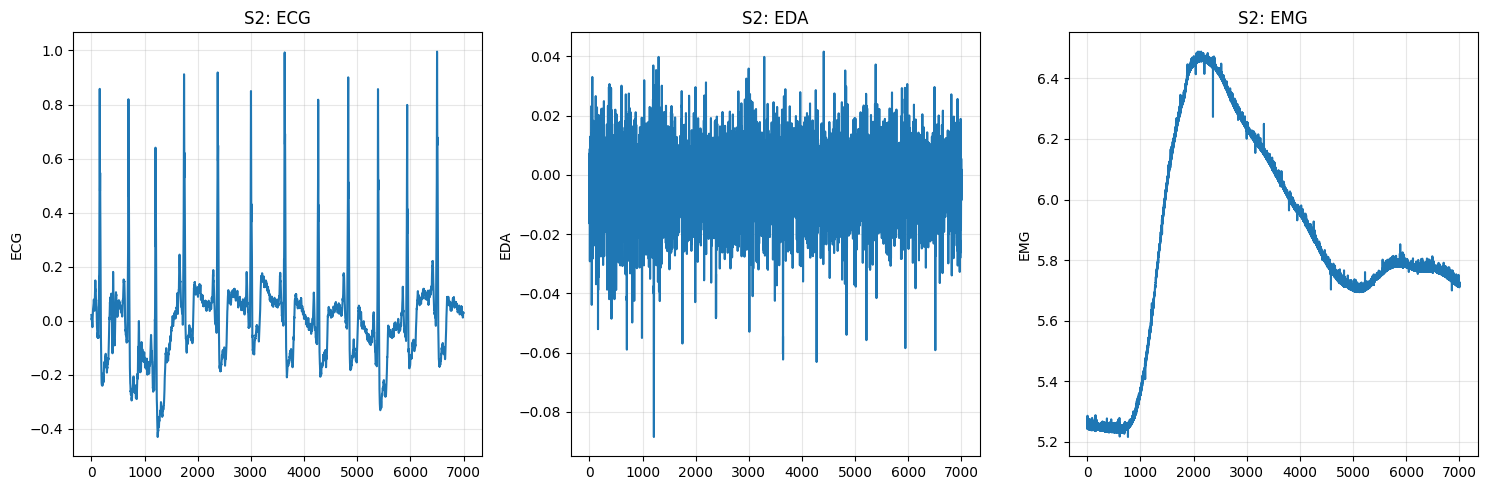

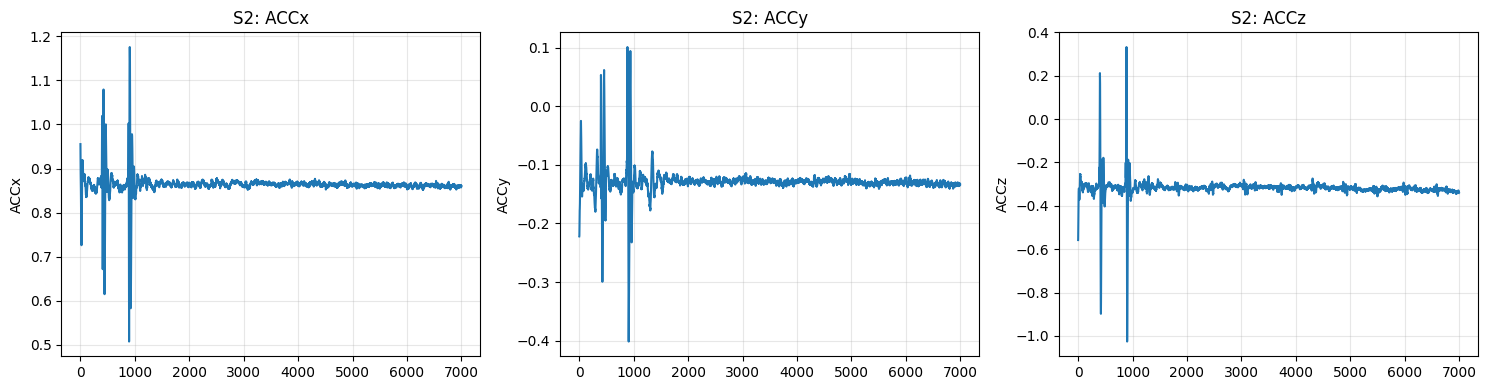

💾 SAVED: /kaggle/working/wesad_outputs/wesad_processed.pkl

✅ Built window‑level arrays: X_all (86868, 700, 8), y_all (86868,), subj_all (86868,)
✅ STEP 1 100% COMPLETE! Ready for redesigned Step 2 (splits).


In [1]:
# ============================
# STEP 1 – Load WESAD, fix chest dicts, and build window‑ready arrays
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

print("🚀 STEP 1 FINAL: WESAD Chest Dict → Unified Array + Subject IDs")

subjects = ['2','3','4','5','6','7','8','9','10','11','13','14','15','16','17']
data_base_path = '/kaggle/input/wesad-wearable-stress-affect-detection-dataset/WESAD'
data = {}

def fix_chest_dict(chest_dict):
    """
    Convert WESAD chest dict with variable‑length channels into
    a unified (N, 8) array in the order:
    [ACCx, ACCy, ACCz, ECG, EDA, EMG, RESP, TEMP]
    """
    keys = list(chest_dict.keys())
    max_len = max(len(chest_dict[k]) for k in keys)
    
    fixed_channels = []

    for key in ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']:
        if key in chest_dict:
            arr = chest_dict[key]
            # ACC is (N,3); others are (N,) or (N,1)
            if len(arr.shape) == 2 and arr.shape[1] == 3:  # ACC
                for i in range(3):
                    padded = np.pad(arr[:, i], (0, max_len - len(arr)), 'constant')
                    fixed_channels.append(padded[:max_len])
            else:
                padded = np.pad(arr.flatten(), (0, max_len - len(arr)), 'constant')
                fixed_channels.append(padded[:max_len])

    chest_array = np.stack(fixed_channels, axis=1)  # (max_len, 8)
    return chest_array

# ---------- Load ALL subjects and build 'data' dict ----------
for subj in subjects:
    pkl_path = f'{data_base_path}/S{subj}/S{subj}.pkl'
    if Path(pkl_path).exists():
        raw_data = pd.read_pickle(pkl_path)
        chest_dict = raw_data['signal']['chest']
        
        chest_array = fix_chest_dict(chest_dict)  # (T,8)
        data[subj] = {
            'raw': raw_data,
            'chest': chest_array,
            'label': raw_data['label']  # (T,)
        }
        print(f"✅ S{subj}: {chest_array.shape} (8 channels)")
    else:
        print(f"❌ S{subj} missing")

print(f"\n📊 Loaded {len(data)}/15 subjects")

# ---------- Quick visualization for S2 (same as your original) ----------
if '2' in data:
    chest = data['2']['chest']
    labels = data['2']['label']
    
    print(f"🎯 S2 shape: {chest.shape}")
    uniq, counts = np.unique(labels, return_counts=True)
    print(f"📈 Labels: {uniq} = {counts}")
    
    output_dir = '/kaggle/working/wesad_outputs'
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(15, 5))
    channel_names = ['ACCx','ACCy','ACCz','ECG','EDA','EMG','RESP','TEMP']

    # ECG, EDA, EMG
    for i, name in enumerate(['ECG','EDA','EMG']):
        plt.subplot(1,3,i+1)
        plt.plot(chest[:7000, 3+i])
        plt.title(f'S2: {name}')
        plt.ylabel(name)
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/step1_chest_ecg_eda_emg.png', dpi=150, bbox_inches='tight')
    plt.show()

    # ACCx, ACCy, ACCz
    plt.figure(figsize=(15, 4))
    for i, name in enumerate(['ACCx','ACCy','ACCz']):
        plt.subplot(1,3,i+1)
        plt.plot(chest[:7000, i])
        plt.title(f'S2: {name}')
        plt.ylabel(name)
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/step1_chest_acc.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Save processed dict
    with open(f'{output_dir}/wesad_processed.pkl', 'wb') as f:
        pickle.dump(data, f)
    print(f"💾 SAVED: {output_dir}/wesad_processed.pkl")

# ---------- NEW PART: Build unified arrays for later steps ----------
fs = 700          # chest sampling rate
window_size = fs  # 1‑second windows

def map_to_binary_stress(label_array):
    """
    Map WESAD original labels to binary:
    2 (baseline) + 3 (amusement) + 0 (transitions) -> 0 (non‑stress)
    4 (TSST stress) -> 1 (stress)
    Adjust if you use a different mapping.
    """
    lab = np.array(label_array)
    bin_lab = np.zeros_like(lab)
    bin_lab[lab == 4] = 1
    return bin_lab

def majority_vote(labels):
    vals, counts = np.unique(labels, return_counts=True)
    return vals[np.argmax(counts)]

all_windows = []
all_labels = []
all_subject_ids = []

for subj in subjects:
    if subj not in data:
        continue
    chest = data[subj]['chest']          # (T,8)
    labels = np.array(data[subj]['label'])  # (T,)
    bin_labels = map_to_binary_stress(labels)

    # create non‑overlapping 1‑second windows
    for start in range(0, len(chest) - window_size + 1, window_size):
        end = start + window_size
        win_x = chest[start:end]         # (700,8)
        win_y = majority_vote(bin_labels[start:end])
        all_windows.append(win_x)
        all_labels.append(win_y)
        all_subject_ids.append(int(subj))

X_all = np.stack(all_windows)            # (N,700,8)
y_all = np.array(all_labels)            # (N,)
subj_all = np.array(all_subject_ids)    # (N,)

np.save(f"{output_dir}/X_all.npy", X_all)
np.save(f"{output_dir}/y_all.npy", y_all)
np.save(f"{output_dir}/subj_all.npy", subj_all)

print(f"\n✅ Built window‑level arrays: X_all {X_all.shape}, y_all {y_all.shape}, subj_all {subj_all.shape}")
print("✅ STEP 1 100% COMPLETE! Ready for redesigned Step 2 (splits).")

In [4]:
# ============================
# STEP 2: Safe Preprocessing for TinyXAI (window-wise + subject-wise)
# - Global norm for window-wise
# - Per-subject norm for subject-wise
# - Light, balanced augmentation on a subset (no huge RAM spikes)
# ============================

import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("🚀 STEP 2: SAFE Preprocessing (per-subject norm + light augmentation)")

out_dir = "/kaggle/working/wesad_outputs"
os.makedirs(out_dir, exist_ok=True)

# 1) Load Step‑1 window-level arrays
X_all = np.load(f"{out_dir}/X_all.npy")       # (N,700,8)
y_all = np.load(f"{out_dir}/y_all.npy")       # (N,)
subj_all = np.load(f"{out_dir}/subj_all.npy") # (N,)
X_all = X_all.astype("float32")               # keep memory lower

print(f"✅ Loaded from Step 1: X_all {X_all.shape}, y_all {y_all.shape}, subj_all {subj_all.shape}")

# -----------------------------
# Helper 1: Global scaler (window-wise)
# -----------------------------
def fit_and_apply_scaler_global(X_train, X_val, X_test):
    N_train, T, C = X_train.shape
    scaler = StandardScaler()
    X_train_2d = X_train.reshape(N_train, T * C)
    X_train_2d = scaler.fit_transform(X_train_2d)
    X_train = X_train_2d.reshape(N_train, T, C)

    def apply(X):
        N, T, C = X.shape
        X2 = X.reshape(N, T * C)
        X2 = scaler.transform(X2)
        return X2.reshape(N, T, C)

    X_val  = apply(X_val)
    X_test = apply(X_test)
    return X_train, X_val, X_test, scaler

# -----------------------------
# Helper 2: Per-subject normalization (memory-safe)
# -----------------------------
def per_subject_normalization(X_train, subj_train, X_val, X_test, subj_val, subj_test):
    """
    Normalize each subject in train with its own scaler.
    For val/test subjects (unseen), use a global scaler fitted on ALL train data.
    """
    scaler_per_subject = {}

    # Subject-specific scalers for training subjects
    unique_train_subj = np.unique(subj_train)
    for sid in unique_train_subj:
        mask = subj_train == sid
        subj_data = X_train[mask].reshape(-1, X_train.shape[-1])
        scaler = StandardScaler()
        scaler.fit(subj_data)
        scaler_per_subject[int(sid)] = scaler

    # Global scaler (fallback for unseen subjects)
    global_scaler = StandardScaler()
    global_scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

    def apply_scalers(X, subj_ids):
        X_norm = np.empty_like(X, dtype="float32")
        for sid in np.unique(subj_ids):
            mask = subj_ids == sid
            if int(sid) in scaler_per_subject:
                scaler = scaler_per_subject[int(sid)]
            else:
                scaler = global_scaler
            d = X[mask].reshape(-1, X.shape[-1])
            d = scaler.transform(d)
            X_norm[mask] = d.reshape(-1, X.shape[1], X.shape[2])
        return X_norm

    X_train_norm = apply_scalers(X_train, subj_train)
    X_val_norm   = apply_scalers(X_val,   subj_val)
    X_test_norm  = apply_scalers(X_test,  subj_test)

    return X_train_norm, X_val_norm, X_test_norm, scaler_per_subject

# -----------------------------
# Helper 3: LIGHT data augmentation (no huge copies)
# - augment_factor = 2
# - only on a subset of training data
# -----------------------------
def augment_subjectwise_light(X, y, subj, max_samples=30000, augment_factor=2):
    """
    Memory-safe augmentation:
      - randomly select up to max_samples windows
      - create one augmented copy (factor=2 total)
    """
    n = X.shape[0]
    if n > max_samples:
        idx = np.random.choice(n, size=max_samples, replace=False)
        X_base = X[idx]
        y_base = y[idx]
        subj_base = subj[idx]
    else:
        X_base = X
        y_base = y
        subj_base = subj

    # One augmented copy
    X_aug = X_base.copy()

    # Time jitter via np.roll (loop but only on subset)
    jitter = np.random.randint(-14, 15, size=X_base.shape[0])
    for i in range(X_base.shape[0]):
        j = jitter[i]
        if j != 0:
            X_aug[i] = np.roll(X_aug[i], j, axis=0)

    # Amplitude scaling
    scale = np.random.uniform(0.9, 1.1, size=(X_base.shape[0], 1, 1)).astype("float32")
    X_aug *= scale

    # Gaussian noise
    noise = np.random.normal(0, 0.01, size=X_base.shape).astype("float32")
    X_aug += noise

    # Concatenate original full train + augmented subset
    X_out = np.concatenate([X, X_aug], axis=0)
    y_out = np.concatenate([y, y_base], axis=0)
    subj_out = np.concatenate([subj, subj_base], axis=0)

    return X_out, y_out, subj_out

# ----------------------------------------------------------
# PART A – WINDOW‑WISE SPLIT (unchanged)
# ----------------------------------------------------------
print("\n📦 PART A: Window-wise split (global normalization)")

X_train_w, X_temp_w, y_train_w, y_temp_w, subj_train_w, subj_temp_w = train_test_split(
    X_all, y_all, subj_all,
    test_size=0.30,
    random_state=42,
    stratify=y_all
)

X_val_w, X_test_w, y_val_w, y_test_w, subj_val_w, subj_test_w = train_test_split(
    X_temp_w, y_temp_w, subj_temp_w,
    test_size=0.50,
    random_state=42,
    stratify=y_temp_w
)

print("📊 Window-wise label counts:")
for name, arr in [("train", y_train_w), ("val", y_val_w), ("test", y_test_w)]:
    u, c = np.unique(arr, return_counts=True)
    print(f"  {name}: {dict(zip(u, c))}")

X_train_w, X_val_w, X_test_w, scaler_w = fit_and_apply_scaler_global(X_train_w, X_val_w, X_test_w)
print("✅ Window-wise normalization done")

np.save(f"{out_dir}/X_train_w.npy", X_train_w)
np.save(f"{out_dir}/y_train_w.npy", y_train_w)
np.save(f"{out_dir}/X_val_w.npy",   X_val_w)
np.save(f"{out_dir}/y_val_w.npy",   y_val_w)
np.save(f"{out_dir}/X_test_w.npy",  X_test_w)
np.save(f"{out_dir}/y_test_w.npy",  y_test_w)

with open(f"{out_dir}/scaler_w.pkl", "wb") as f:
    pickle.dump(scaler_w, f)

print("💾 Saved window-wise arrays and scaler_w.")

# ----------------------------------------------------------
# PART B – SUBJECT‑WISE SPLIT (safe version)
# ----------------------------------------------------------
print("\n📦 PART B: Subject-wise split (PER-SUBJECT NORM + LIGHT AUGMENTATION)")

train_subjects = [2,3,4,5,6,7,8,9,10,11]
val_subjects   = [13,14]
test_subjects  = [15,16,17]

train_mask = np.isin(subj_all, train_subjects)
val_mask   = np.isin(subj_all, val_subjects)
test_mask  = np.isin(subj_all, test_subjects)

X_train_s, y_train_s, subj_train_s = X_all[train_mask], y_all[train_mask], subj_all[train_mask]
X_val_s,   y_val_s,   subj_val_s   = X_all[val_mask],   y_all[val_mask],   subj_all[val_mask]
X_test_s,  y_test_s,  subj_test_s  = X_all[test_mask],  y_all[test_mask],  subj_all[test_mask]

print("📊 Subject-wise label counts (BEFORE augmentation):")
for name, arr in [("train", y_train_s), ("val", y_val_s), ("test", y_test_s)]:
    u, c = np.unique(arr, return_counts=True)
    print(f"  {name}: {dict(zip(u, c))}")

# Per-subject normalization
print("\n🔧 Applying PER-SUBJECT normalization...")
X_train_s_norm, X_val_s_norm, X_test_s_norm, scaler_s_per_subject = per_subject_normalization(
    X_train_s, subj_train_s,
    X_val_s, X_test_s,
    subj_val_s, subj_test_s
)

# Light augmentation on a subset of training data
print("🔧 Applying LIGHT data augmentation to subject-wise training data...")
X_train_s_aug, y_train_s_aug, subj_train_s_aug = augment_subjectwise_light(
    X_train_s_norm, y_train_s, subj_train_s,
    max_samples=30000,   # at most 30k windows augmented
    augment_factor=2     # 1 extra copy only
)

print("📊 Subject-wise label counts (AFTER augmentation):")
u, c = np.unique(y_train_s_aug, return_counts=True)
print(f"  train_augmented: {dict(zip(u, c))}")

print("✅ Subject-wise preprocessing complete (per-subject norm + light augmentation)")

# Save ALL subject-wise data (this was missing!)
np.save(f"{out_dir}/X_train_s_aug.npy", X_train_s_aug)
np.save(f"{out_dir}/y_train_s_aug.npy", y_train_s_aug)
np.save(f"{out_dir}/X_val_s_norm.npy", X_val_s_norm)
np.save(f"{out_dir}/y_val_s.npy", y_val_s)
np.save(f"{out_dir}/X_test_s_norm.npy", X_test_s_norm)
np.save(f"{out_dir}/y_test_s.npy", y_test_s)

with open(f"{out_dir}/scaler_s_per_subject.pkl", "wb") as f:
    pickle.dump(scaler_s_per_subject, f)

print("💾 Saved ALL subject-wise arrays and scalers.")

print("\n📊 FINAL DIMENSIONS FOR STEP 3:")
print(f"  Window-wise: train {X_train_w.shape}, val {X_val_w.shape}, test {X_test_w.shape}")
print(f"  Subject-wise: train_aug {X_train_s_aug.shape}, val {X_val_s_norm.shape}, test {X_test_s_norm.shape}")

print("\n✅ STEP 2 SAFE COMPLETE – Ready for subject-wise TinyXAI training!")

🚀 STEP 2: SAFE Preprocessing (per-subject norm + light augmentation)
✅ Loaded from Step 1: X_all (86868, 700, 8), y_all (86868,), subj_all (86868,)

📦 PART A: Window-wise split (global normalization)
📊 Window-wise label counts:
  train: {0: 52543, 1: 8264}
  val: {0: 11259, 1: 1771}
  test: {0: 11260, 1: 1771}
✅ Window-wise normalization done
💾 Saved window-wise arrays and scaler_w.

📦 PART B: Subject-wise split (PER-SUBJECT NORM + LIGHT AUGMENTATION)
📊 Subject-wise label counts (BEFORE augmentation):
  train: {0: 51080, 1: 7900}
  val: {0: 9496, 1: 1589}
  test: {0: 14486, 1: 2317}

🔧 Applying PER-SUBJECT normalization...
🔧 Applying LIGHT data augmentation to subject-wise training data...
📊 Subject-wise label counts (AFTER augmentation):
  train_augmented: {0: 77096, 1: 11884}
✅ Subject-wise preprocessing complete (per-subject norm + light augmentation)
💾 Saved ALL subject-wise arrays and scalers.

📊 FINAL DIMENSIONS FOR STEP 3:
  Window-wise: train (60807, 700, 8), val (13030, 700, 8

🚀 STEP 3: TinyXAI CNN-LSTM + Baseline Training (with fixed seeds)
✅ Window-wise shapes:
  X_train_w: (60807, 700, 8)  y_train_w: (60807,)
  X_val_w:   (13030, 700, 8)  y_val_w:   (13030,)
  X_test_w:  (13031, 700, 8)  y_test_w:  (13031,)

✅ Subject-wise shapes:
  X_train_s: (88980, 700, 8)  y_train_s: (88980,)
  X_val_s:   (11085, 700, 8)  y_val_s:   (11085,)
  X_test_s:  (16803, 700, 8)  y_test_s:  (16803,)

EXPERIMENT A1 – Window-wise TinyXAI CNN-LSTM


I0000 00:00:1765523325.249730      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


⚖️  Class weights for tinyxai_window: {0: 0.5786403517119312, 1: 3.6790295256534367}
Epoch 1/60


2025-12-12 07:08:51.216599: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
I0000 00:00:1765523335.082506     130 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-12 07:09:25.578416: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:var

476/476 - 38s - 80ms/step - accuracy: 0.8202 - loss: 0.3824 - precision: 0.4270 - recall: 0.9447 - val_accuracy: 0.9019 - val_loss: 0.3079 - val_precision: 0.5862 - val_recall: 0.9464 - learning_rate: 0.0010
Epoch 2/60
476/476 - 29s - 61ms/step - accuracy: 0.8926 - loss: 0.2983 - precision: 0.5635 - recall: 0.9327 - val_accuracy: 0.9345 - val_loss: 0.2420 - val_precision: 0.6785 - val_recall: 0.9842 - learning_rate: 0.0010
Epoch 3/60
476/476 - 29s - 61ms/step - accuracy: 0.8504 - loss: 0.3176 - precision: 0.4745 - recall: 0.9361 - val_accuracy: 0.9269 - val_loss: 0.2614 - val_precision: 0.6546 - val_recall: 0.9791 - learning_rate: 0.0010
Epoch 4/60
476/476 - 29s - 61ms/step - accuracy: 0.9189 - loss: 0.2390 - precision: 0.6350 - recall: 0.9486 - val_accuracy: 0.9465 - val_loss: 0.2079 - val_precision: 0.7237 - val_recall: 0.9808 - learning_rate: 0.0010
Epoch 5/60
476/476 - 29s - 61ms/step - accuracy: 0.9186 - loss: 0.2377 - precision: 0.6342 - recall: 0.9482 - val_accuracy: 0.9279 - va

💾 Saved tinyxai_window to: /kaggle/working/wesad_outputs/tinyxai_window.h5


2025-12-12 07:37:59.285477: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



📊 Test results [TinyXAI (window-wise)]:
  Loss      : 0.1008
  Accuracy  : 0.9701
  Precision : 0.8259
  Recall    : 0.9881
  F1-score  : 0.8997


2025-12-12 07:38:06.080027: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       1.00      0.97      0.98     11260
      Stress       0.83      0.99      0.90      1771

    accuracy                           0.97     13031
   macro avg       0.91      0.98      0.94     13031
weighted avg       0.97      0.97      0.97     13031



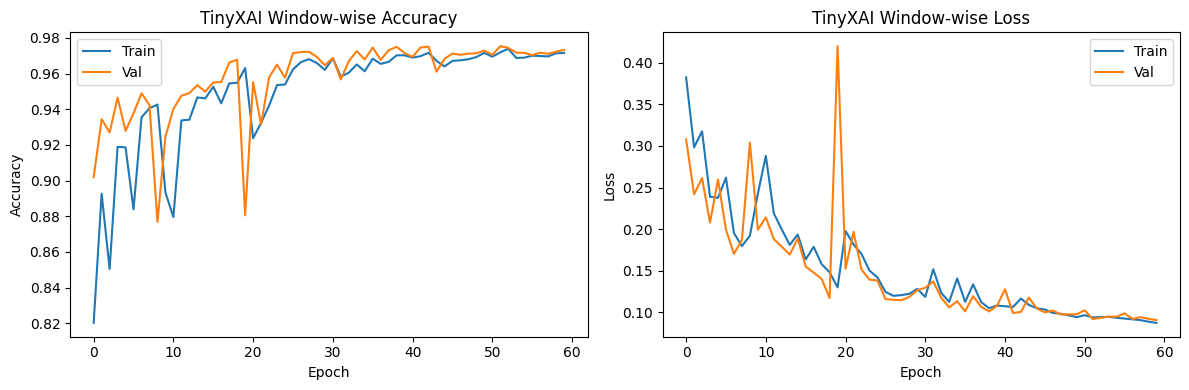


EXPERIMENT A2 – Window-wise 1D-CNN baseline
⚖️  Class weights for cnn_window: {0: 0.5786403517119312, 1: 3.6790295256534367}
Epoch 1/60


2025-12-12 07:38:17.174079: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-12-12 07:38:31.659646: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

476/476 - 17s - 35ms/step - accuracy: 0.8900 - loss: 0.2312 - precision: 0.5561 - recall: 0.9432 - val_accuracy: 0.9035 - val_loss: 0.2849 - val_precision: 0.5856 - val_recall: 0.9927 - learning_rate: 0.0010
Epoch 2/60
476/476 - 12s - 26ms/step - accuracy: 0.9578 - loss: 0.1229 - precision: 0.7759 - recall: 0.9690 - val_accuracy: 0.9596 - val_loss: 0.1365 - val_precision: 0.7743 - val_recall: 0.9915 - learning_rate: 0.0010
Epoch 3/60
476/476 - 12s - 26ms/step - accuracy: 0.9664 - loss: 0.1000 - precision: 0.8140 - recall: 0.9753 - val_accuracy: 0.9672 - val_loss: 0.1004 - val_precision: 0.8091 - val_recall: 0.9932 - learning_rate: 0.0010
Epoch 4/60
476/476 - 12s - 26ms/step - accuracy: 0.9703 - loss: 0.0840 - precision: 0.8320 - recall: 0.9789 - val_accuracy: 0.9693 - val_loss: 0.0958 - val_precision: 0.8193 - val_recall: 0.9932 - learning_rate: 0.0010
Epoch 5/60
476/476 - 12s - 26ms/step - accuracy: 0.9722 - loss: 0.0776 - precision: 0.8412 - recall: 0.9804 - val_accuracy: 0.9716 - va

💾 Saved cnn_window to: /kaggle/working/wesad_outputs/cnn_window.h5


2025-12-12 07:48:09.907638: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



📊 Test results [1D-CNN (window-wise)]:
  Loss      : 0.0453
  Accuracy  : 0.9881
  Precision : 0.9293
  Recall    : 0.9876
  F1-score  : 0.9576

📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       1.00      0.99      0.99     11260
      Stress       0.93      0.99      0.96      1771

    accuracy                           0.99     13031
   macro avg       0.96      0.99      0.98     13031
weighted avg       0.99      0.99      0.99     13031



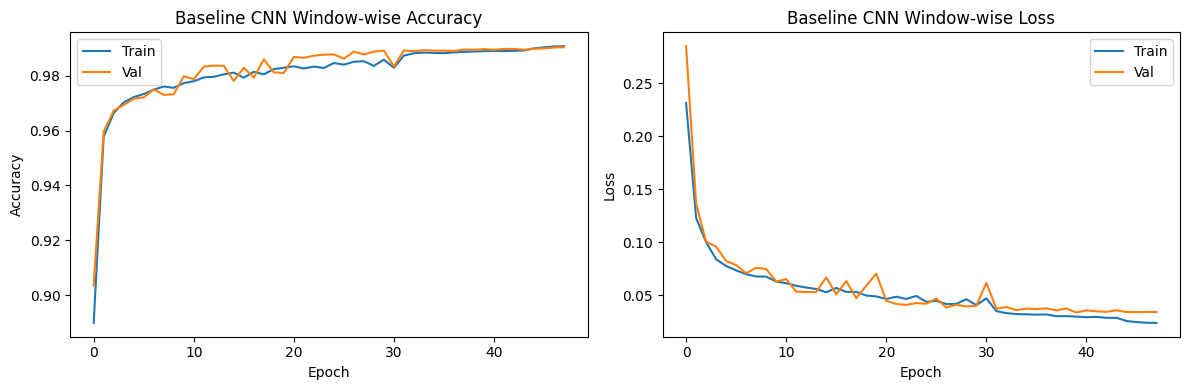


EXPERIMENT B1 – Subject-wise TinyXAI CNN-LSTM
⚖️  Class weights for tinyxai_subject: {0: 0.5770727404794023, 1: 3.743688993604847}
Epoch 1/60


2025-12-12 07:48:20.798787: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-12-12 07:49:04.434127: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

696/696 - 47s - 68ms/step - accuracy: 0.9288 - loss: 0.2209 - precision: 0.6586 - recall: 0.9689 - val_accuracy: 0.7521 - val_loss: 0.9074 - val_precision: 0.3111 - val_recall: 0.6004 - learning_rate: 0.0010
Epoch 2/60
696/696 - 41s - 59ms/step - accuracy: 0.9519 - loss: 0.1541 - precision: 0.7451 - recall: 0.9726 - val_accuracy: 0.7569 - val_loss: 0.9220 - val_precision: 0.3418 - val_recall: 0.7520 - learning_rate: 0.0010
Epoch 3/60
696/696 - 41s - 59ms/step - accuracy: 0.9462 - loss: 0.1629 - precision: 0.7210 - recall: 0.9736 - val_accuracy: 0.7603 - val_loss: 0.8357 - val_precision: 0.3262 - val_recall: 0.6306 - learning_rate: 0.0010
Epoch 4/60
696/696 - 41s - 59ms/step - accuracy: 0.9527 - loss: 0.1413 - precision: 0.7461 - recall: 0.9790 - val_accuracy: 0.7625 - val_loss: 0.9196 - val_precision: 0.3376 - val_recall: 0.6828 - learning_rate: 0.0010
Epoch 5/60
696/696 - 41s - 59ms/step - accuracy: 0.9537 - loss: 0.1499 - precision: 0.7547 - recall: 0.9683 - val_accuracy: 0.7308 - va

💾 Saved tinyxai_subject to: /kaggle/working/wesad_outputs/tinyxai_subject.h5


2025-12-12 07:55:58.675782: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



📊 Test results [TinyXAI (subject-wise)]:
  Loss      : 0.8819
  Accuracy  : 0.7871
  Precision : 0.3116
  Recall    : 0.4502
  F1-score  : 0.3683


2025-12-12 07:56:07.492606: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       0.91      0.84      0.87     14486
      Stress       0.31      0.45      0.37      2317

    accuracy                           0.79     16803
   macro avg       0.61      0.65      0.62     16803
weighted avg       0.82      0.79      0.80     16803



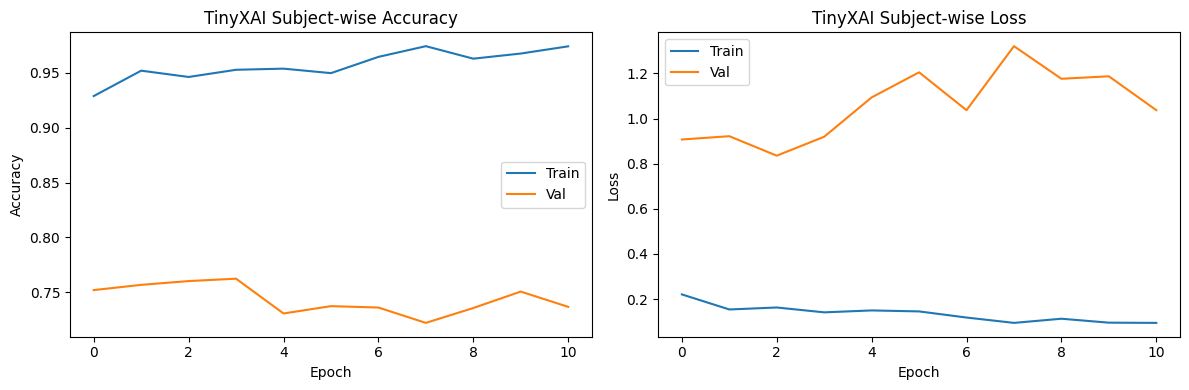


EXPERIMENT B2 – Subject-wise 1D-CNN baseline
⚖️  Class weights for cnn_subject: {0: 0.5770727404794023, 1: 3.743688993604847}
Epoch 1/60


2025-12-12 07:56:21.869794: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-12-12 07:56:41.605180: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

696/696 - 22s - 32ms/step - accuracy: 0.9487 - loss: 0.1357 - precision: 0.7306 - recall: 0.9757 - val_accuracy: 0.8065 - val_loss: 0.8601 - val_precision: 0.4234 - val_recall: 0.9666 - learning_rate: 0.0010
Epoch 2/60
696/696 - 18s - 25ms/step - accuracy: 0.9730 - loss: 0.0813 - precision: 0.8417 - recall: 0.9827 - val_accuracy: 0.8019 - val_loss: 0.8915 - val_precision: 0.3968 - val_recall: 0.7344 - learning_rate: 0.0010
Epoch 3/60
696/696 - 18s - 25ms/step - accuracy: 0.9801 - loss: 0.0631 - precision: 0.8799 - recall: 0.9855 - val_accuracy: 0.8124 - val_loss: 0.9142 - val_precision: 0.4063 - val_recall: 0.6702 - learning_rate: 0.0010
Epoch 4/60
696/696 - 18s - 25ms/step - accuracy: 0.9824 - loss: 0.0541 - precision: 0.8914 - recall: 0.9885 - val_accuracy: 0.8124 - val_loss: 1.0707 - val_precision: 0.4116 - val_recall: 0.7174 - learning_rate: 0.0010
Epoch 5/60

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
696/696 - 18s - 25ms/step - accuracy: 0.9836 - 

💾 Saved cnn_subject to: /kaggle/working/wesad_outputs/cnn_subject.h5


2025-12-12 07:59:04.706933: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



📊 Test results [1D-CNN (subject-wise)]:
  Loss      : 1.2587
  Accuracy  : 0.7862
  Precision : 0.2810
  Recall    : 0.3530
  F1-score  : 0.3129

📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       0.89      0.86      0.87     14486
      Stress       0.28      0.35      0.31      2317

    accuracy                           0.79     16803
   macro avg       0.59      0.60      0.59     16803
weighted avg       0.81      0.79      0.80     16803



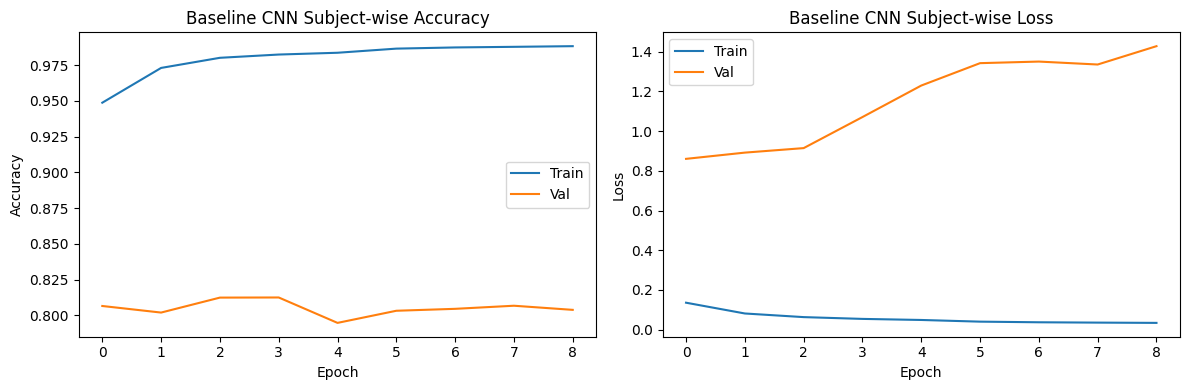


✅ STEP 3 COMPLETE (deterministic as far as TF/GPU allow)


In [5]:
# ============================
# STEP 3: TinyXAI Models + CNN Baseline (REPRODUCIBLE)
# ============================

import os
import random
import numpy as np
import tensorflow as tf

# ---------- 0) MAKE RUNS REPRODUCIBLE ----------
seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"   # may slow slightly, but more deterministic

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Optional: restrict TF threads for extra stability
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

print("🚀 STEP 3: TinyXAI CNN-LSTM + Baseline Training (with fixed seeds)")

out_dir = "/kaggle/working/wesad_outputs"
os.makedirs(out_dir, exist_ok=True)

# ---------- 1) Load WINDOW-WISE data (saved in Step 2) ----------
X_train_w = np.load(f"{out_dir}/X_train_w.npy").astype("float32")
y_train_w = np.load(f"{out_dir}/y_train_w.npy")
X_val_w   = np.load(f"{out_dir}/X_val_w.npy").astype("float32")
y_val_w   = np.load(f"{out_dir}/y_val_w.npy")
X_test_w  = np.load(f"{out_dir}/X_test_w.npy").astype("float32")
y_test_w  = np.load(f"{out_dir}/y_test_w.npy")

print("✅ Window-wise shapes:")
print("  X_train_w:", X_train_w.shape, " y_train_w:", y_train_w.shape)
print("  X_val_w:  ", X_val_w.shape,   " y_val_w:  ", y_val_w.shape)
print("  X_test_w: ", X_test_w.shape,  " y_test_w: ", y_test_w.shape)

input_shape = X_train_w.shape[1:]   # (700, 8)

# ---------- 1b) Load SUBJECT-WISE data (saved in Step 2) ----------
X_train_s = np.load(f"{out_dir}/X_train_s_aug.npy").astype("float32")
y_train_s = np.load(f"{out_dir}/y_train_s_aug.npy")
X_val_s   = np.load(f"{out_dir}/X_val_s_norm.npy").astype("float32")
y_val_s   = np.load(f"{out_dir}/y_val_s.npy")
X_test_s  = np.load(f"{out_dir}/X_test_s_norm.npy").astype("float32")
y_test_s  = np.load(f"{out_dir}/y_test_s.npy")

print("\n✅ Subject-wise shapes:")
print("  X_train_s:", X_train_s.shape, " y_train_s:", y_train_s.shape)
print("  X_val_s:  ", X_val_s.shape,   " y_val_s:  ", y_val_s.shape)
print("  X_test_s: ", X_test_s.shape,  " y_test_s: ", y_test_s.shape)

input_shape_s = X_train_s.shape[1:]

# ---------- 2) Define models (unchanged) ----------
def build_tiny_cnn_lstm(input_shape):
    inp = layers.Input(shape=input_shape, name="input_layer")
    x = layers.Conv1D(32, 5, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.LSTM(64, return_sequences=False,
                    kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inp, out, name="TinyXAI_CNN_LSTM")
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

def build_cnn_only(input_shape):
    inp = layers.Input(shape=input_shape, name="input_layer")
    x = layers.Conv1D(32, 5, padding="same", activation="relu")(inp)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inp, out, name="Baseline_1D_CNN")
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

# ---------- 3) Training / evaluation helpers ----------
def train_model(model, X_train, y_train, X_val, y_val, model_name):
    # class weights deterministic because y_train is fixed
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(y_train), y=y_train
    )
    cw = {0: class_weights[0], 1: class_weights[1]}
    print(f"⚖️  Class weights for {model_name}: {cw}")

    es = callbacks.EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    )
    rlrop = callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=60,
        batch_size=128,
        callbacks=[es, rlrop],
        class_weight=cw,
        verbose=2,
        shuffle=True,   # shuffling uses fixed TF seed now
    )

    path = f"{out_dir}/{model_name}.h5"
    model.save(path)
    print(f"💾 Saved {model_name} to:", path)
    return model, history, path

def evaluate_and_report(model, X_test, y_test, tag):
    loss, acc, prec, rec = model.evaluate(X_test, y_test, verbose=0)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    print(f"\n📊 Test results [{tag}]:")
    print(f"  Loss      : {loss:.4f}")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1-score  : {f1:.4f}")

    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    print("\n📈 Classification report:")
    print(classification_report(y_test, y_pred, target_names=["Non-Stress","Stress"]))
    return {"loss": loss, "acc": acc, "prec": prec, "rec": rec, "f1": f1}

def plot_history(history, title_prefix, filename):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Val")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{out_dir}/{filename}", dpi=150, bbox_inches="tight")
    plt.show()

# ---------- 4) Experiment A1 – Window-wise TinyXAI ----------
print("\n==========================")
print("EXPERIMENT A1 – Window-wise TinyXAI CNN-LSTM")
print("==========================")

tiny_w = build_tiny_cnn_lstm(input_shape)
tiny_w, hist_tiny_w, path_tiny_w = train_model(
    tiny_w, X_train_w, y_train_w, X_val_w, y_val_w, "tinyxai_window"
)
metrics_tiny_w = evaluate_and_report(tiny_w, X_test_w, y_test_w, "TinyXAI (window-wise)")
plot_history(hist_tiny_w, "TinyXAI Window-wise", "history_tinyxai_window.png")

# ---------- 5) Experiment A2 – Window-wise 1D-CNN baseline ----------
print("\n==========================")
print("EXPERIMENT A2 – Window-wise 1D-CNN baseline")
print("==========================")

cnn_w = build_cnn_only(input_shape)
cnn_w, hist_cnn_w, path_cnn_w = train_model(
    cnn_w, X_train_w, y_train_w, X_val_w, y_val_w, "cnn_window"
)
metrics_cnn_w = evaluate_and_report(cnn_w, X_test_w, y_test_w, "1D-CNN (window-wise)")
plot_history(hist_cnn_w, "Baseline CNN Window-wise", "history_cnn_window.png")

# ---------- 6) SUBJECT-WISE experiments ----------
print("\n==========================")
print("EXPERIMENT B1 – Subject-wise TinyXAI CNN-LSTM")
print("==========================")

tiny_s = build_tiny_cnn_lstm(input_shape_s)
tiny_s, hist_tiny_s, path_tiny_s = train_model(
    tiny_s, X_train_s, y_train_s, X_val_s, y_val_s, "tinyxai_subject"
)
metrics_tiny_s = evaluate_and_report(tiny_s, X_test_s, y_test_s, "TinyXAI (subject-wise)")
plot_history(hist_tiny_s, "TinyXAI Subject-wise", "history_tinyxai_subject.png")

print("\n==========================")
print("EXPERIMENT B2 – Subject-wise 1D-CNN baseline")
print("==========================")

cnn_s = build_cnn_only(input_shape_s)
cnn_s, hist_cnn_s, path_cnn_s = train_model(
    cnn_s, X_train_s, y_train_s, X_val_s, y_val_s, "cnn_subject"
)
metrics_cnn_s = evaluate_and_report(cnn_s, X_test_s, y_test_s, "1D-CNN (subject-wise)")
plot_history(hist_cnn_s, "Baseline CNN Subject-wise", "history_cnn_subject.png")

print("\n✅ STEP 3 COMPLETE (deterministic as far as TF/GPU allow)")

✅ Loaded TinyXAI model from: /kaggle/working/wesad_outputs/tinyxai_window.h5
✅ Loaded WINDOW-wise test data: (13031, 700, 8) (13031,)

🔎 Aggregating IG (WINDOW-wise) for stress class (1)...
  Used 200 stress windows.
🔎 Aggregating IG (WINDOW-wise) for non-stress class (0)...
  Used 200 non-stress windows.


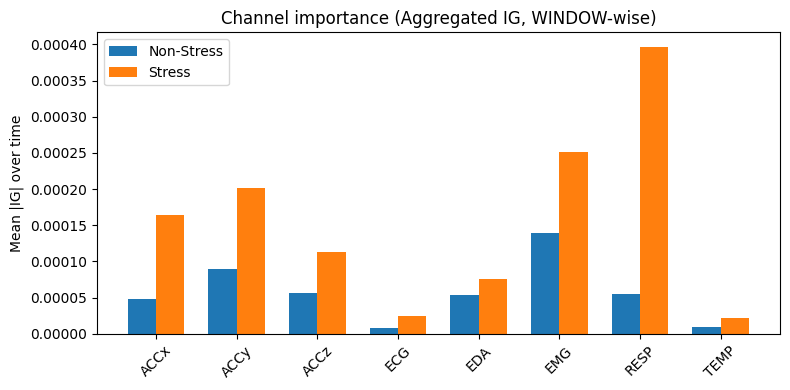

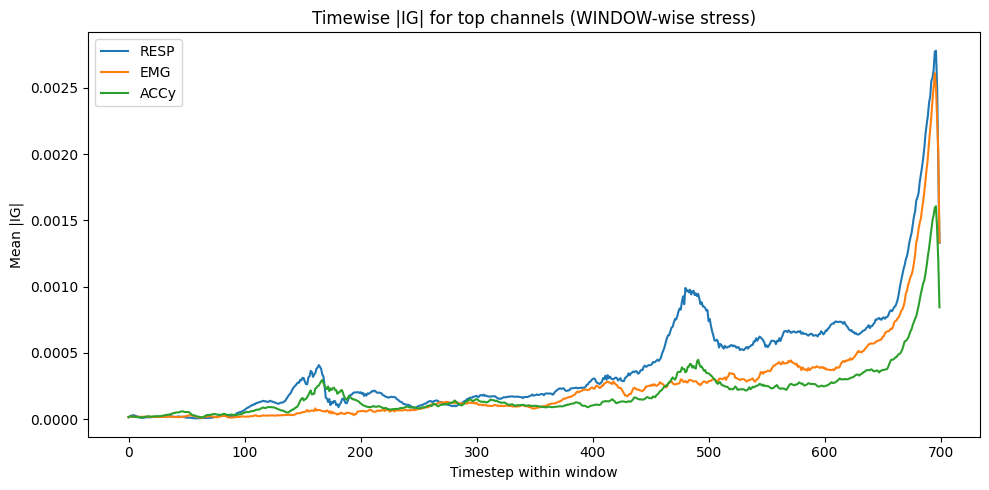


✅ Loaded SUBJECT-wise test data: (16803, 700, 8) (16803,)

🔎 Aggregating IG (SUBJECT-wise) for stress class (1)...
  Used 200 stress windows (subject-wise test).
🔎 Aggregating IG (SUBJECT-wise) for non-stress class (0)...
  Used 200 non-stress windows (subject-wise test).


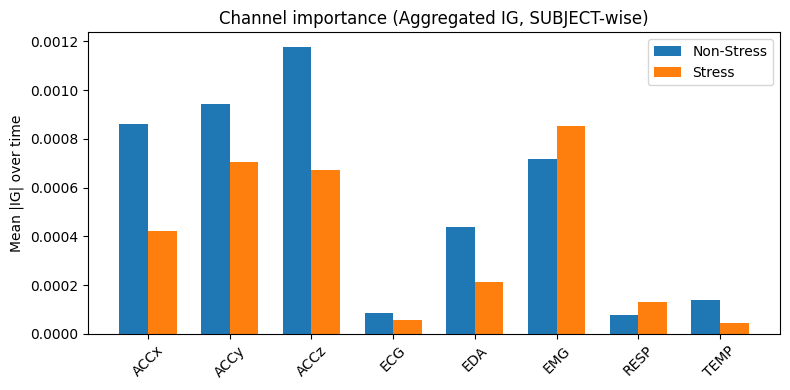

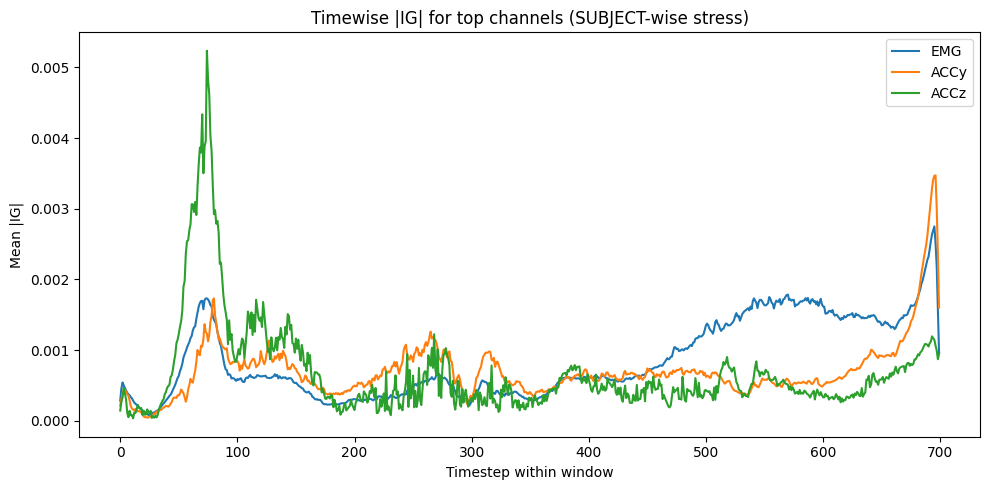


✅ STEP 4 COMPLETE – saved plots to: /kaggle/working/wesad_outputs


In [6]:
# ============================
# STEP 4: Aggregated Integrated Gradients for TinyXAI
# - WINDOW-WISE IG (A)
# - SUBJECT-WISE IG (B)
# ============================

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

out_dir = "/kaggle/working/wesad_outputs"
os.makedirs(out_dir, exist_ok=True)

channel_names = ['ACCx','ACCy','ACCz','ECG','EDA','EMG','RESP','TEMP']

# -------------------------------------------------
# 1) Load TinyXAI model (trained on window-wise data)
# -------------------------------------------------
model_path = f"{out_dir}/tinyxai_window.h5"
model = tf.keras.models.load_model(model_path)
print("✅ Loaded TinyXAI model from:", model_path)

# -------------------------------------------------
# 2) IG utilities (shared by both splits)
# -------------------------------------------------
@tf.function
def interpolate_inputs(baseline, x, alphas):
    # baseline, x: (1,700,8); alphas: (m,)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis]
    delta = x - baseline
    return baseline + alphas_x * delta

@tf.function
def compute_gradients(inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs, training=False)
    return tape.gradient(preds, inputs)

def integrated_gradients(x, baseline=None, m_steps=50):
    """
    x: np.array shape (1,700,8)
    baseline: same shape or None (zeros)
    returns: (700,8) IG attribution
    """
    x = tf.cast(x, tf.float32)
    if baseline is None:
        baseline = tf.zeros_like(x)
    else:
        baseline = tf.cast(baseline, tf.float32)

    alphas = tf.linspace(0.0, 1.0, m_steps + 1)          # (m+1,)
    interpolated = interpolate_inputs(baseline, x, alphas)  # (m+1,700,8)

    grads = compute_gradients(interpolated)              # (m+1,700,8)
    grads = (grads[:-1] + grads[1:]) / 2.0               # trapezoid rule
    avg_grads = tf.reduce_mean(grads, axis=0)            # (700,8)

    ig = (x[0] - baseline[0]) * avg_grads               # (700,8)
    return ig.numpy()

def aggregate_ig_for_class(X, y, target_class, max_samples=200, m_steps=50, seed=42):
    """
    Average |IG| over up to max_samples windows of a given class.
    Returns:
      ig_mean: (700,8) mean |IG| over time and samples
      chan_importance: (8,) mean |IG| per channel
      count: number of windows used
    """
    idx = np.where(y == target_class)[0]
    if len(idx) == 0:
        raise ValueError(f"No samples of class {target_class}.")
    if len(idx) > max_samples:
        rng = np.random.RandomState(seed)   # fixed sampling for reproducibility
        idx = rng.choice(idx, size=max_samples, replace=False)

    ig_sum = None
    count = 0
    for i in idx:
        x = X[i:i+1]
        ig = integrated_gradients(x, m_steps=m_steps)    # (700,8)
        if ig_sum is None:
            ig_sum = np.abs(ig)
        else:
            ig_sum += np.abs(ig)
        count += 1

    ig_mean = ig_sum / count                            # (700,8)
    chan_importance = ig_mean.mean(axis=0)              # (8,)
    return ig_mean, chan_importance, count

def plot_channel_bars(chan_imp_non, chan_imp_stress, title, filename):
    x_pos = np.arange(len(channel_names))
    width = 0.35
    plt.figure(figsize=(8,4))
    plt.bar(x_pos - width/2, chan_imp_non, width, label='Non-Stress')
    plt.bar(x_pos + width/2, chan_imp_stress, width, label='Stress')
    plt.xticks(x_pos, channel_names, rotation=45)
    plt.ylabel("Mean |IG| over time")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{filename}", dpi=150, bbox_inches="tight")
    plt.show()

def plot_timecourse(ig_mean_stress, chan_imp_stress, title, filename, top_k=3):
    top_idx = np.argsort(-chan_imp_stress)[:top_k]
    plt.figure(figsize=(10,5))
    for i in top_idx:
        plt.plot(np.abs(ig_mean_stress[:, i]), label=channel_names[i])
    plt.title(title)
    plt.xlabel("Timestep within window")
    plt.ylabel("Mean |IG|")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{out_dir}/{filename}", dpi=150, bbox_inches="tight")
    plt.show()

# -------------------------------------------------
# PART A – WINDOW-WISE IG
# -------------------------------------------------
X_test_w = np.load(f"{out_dir}/X_test_w.npy")
y_test_w = np.load(f"{out_dir}/y_test_w.npy")
print("✅ Loaded WINDOW-wise test data:", X_test_w.shape, y_test_w.shape)

print("\n🔎 Aggregating IG (WINDOW-wise) for stress class (1)...")
ig_mean_stress_w, chan_imp_stress_w, n_stress_w = aggregate_ig_for_class(
    X_test_w, y_test_w, target_class=1, max_samples=200, m_steps=50, seed=42
)
print("  Used", n_stress_w, "stress windows.")

print("🔎 Aggregating IG (WINDOW-wise) for non-stress class (0)...")
ig_mean_non_w, chan_imp_non_w, n_non_w = aggregate_ig_for_class(
    X_test_w, y_test_w, target_class=0, max_samples=200, m_steps=50, seed=43
)
print("  Used", n_non_w, "non-stress windows.")

plot_channel_bars(
    chan_imp_non_w, chan_imp_stress_w,
    title="Channel importance (Aggregated IG, WINDOW-wise)",
    filename="ig_channels_windowwise.png"
)

plot_timecourse(
    ig_mean_stress_w, chan_imp_stress_w,
    title="Timewise |IG| for top channels (WINDOW-wise stress)",
    filename="ig_timecourse_windowwise_stress.png"
)

# -------------------------------------------------
# PART B – SUBJECT-WISE IG
# -------------------------------------------------
# If your normalized test file is named differently, adjust this line.
X_test_s = np.load(f"{out_dir}/X_test_s_norm.npy")
y_test_s = np.load(f"{out_dir}/y_test_s.npy")
print("\n✅ Loaded SUBJECT-wise test data:", X_test_s.shape, y_test_s.shape)

print("\n🔎 Aggregating IG (SUBJECT-wise) for stress class (1)...")
ig_mean_stress_s, chan_imp_stress_s, n_stress_s = aggregate_ig_for_class(
    X_test_s, y_test_s, target_class=1, max_samples=200, m_steps=50, seed=44
)
print("  Used", n_stress_s, "stress windows (subject-wise test).")

print("🔎 Aggregating IG (SUBJECT-wise) for non-stress class (0)...")
ig_mean_non_s, chan_imp_non_s, n_non_s = aggregate_ig_for_class(
    X_test_s, y_test_s, target_class=0, max_samples=200, m_steps=50, seed=45
)
print("  Used", n_non_s, "non-stress windows (subject-wise test).")

plot_channel_bars(
    chan_imp_non_s, chan_imp_stress_s,
    title="Channel importance (Aggregated IG, SUBJECT-wise)",
    filename="ig_channels_subjectwise.png"
)

plot_timecourse(
    ig_mean_stress_s, chan_imp_stress_s,
    title="Timewise |IG| for top channels (SUBJECT-wise stress)",
    filename="ig_timecourse_subjectwise_stress.png"
)

print("\n✅ STEP 4 COMPLETE – saved plots to:", out_dir)


In [7]:
# ============================
# STEP 5: Final Evaluation + Model Characteristics (Research Version)
# ============================

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import time

out_dir = "/kaggle/working/wesad_outputs"

channel_names = ['ACCx','ACCy','ACCz','ECG','EDA','EMG','RESP','TEMP']

print("🚀 STEP 5: Comprehensive evaluation of all models + splits")

# 1) Load all models and test data
models = {}
test_data = {}

# Window-wise models and data
models['tinyxai_window'] = tf.keras.models.load_model(f"{out_dir}/tinyxai_window.h5")
models['cnn_window']     = tf.keras.models.load_model(f"{out_dir}/cnn_window.h5")

test_data['window'] = {
    'X': np.load(f"{out_dir}/X_test_w.npy").astype("float32"),
    'y': np.load(f"{out_dir}/y_test_w.npy")
}

# Subject-wise models and data
models['tinyxai_subject'] = tf.keras.models.load_model(f"{out_dir}/tinyxai_subject.h5")
models['cnn_subject']     = tf.keras.models.load_model(f"{out_dir}/cnn_subject.h5")

# Prefer in-memory arrays from Step 2; otherwise load from disk
try:
    Xs = X_test_s.astype("float32")
    ys = y_test_s
    print("✅ Using subject-wise test data from memory (Step 2)")
except NameError:
    Xs = np.load(f"{out_dir}/X_test_s_norm.npy").astype("float32")  # ← change here
    ys = np.load(f"{out_dir}/y_test_s.npy")
    print("✅ Using subject-wise test data from disk")


test_data['subject'] = {'X': Xs, 'y': ys}

print("\n📊 Test set shapes:")
for split, data in test_data.items():
    print(f"  {split}: X_test {data['X'].shape}, y_test {data['y'].shape}")

# 2) Comprehensive evaluation function
def evaluate_model(model, X_test, y_test, model_name, split):
    # Metrics from Keras
    loss, acc, prec, rec = model.evaluate(X_test, y_test, verbose=0)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    
    # Detailed classification report
    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    report = classification_report(
        y_test, y_pred,
        target_names=['Non-Stress', 'Stress'],
        output_dict=True
    )
    
    print(f"\n{'='*60}")
    print(f"📊 {model_name} ({split} split)")
    print(f"{'='*60}")
    print(f"  Loss      : {loss:.4f}")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1-score  : {f1:.4f}")
    print(f"\n  Detailed report:")
    print(f"    Stress F1:     {report['Stress']['f1-score']:.4f}")
    print(f"    Non-Stress F1: {report['Non-Stress']['f1-score']:.4f}")
    
    return {
        'loss': loss, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1,
        'stress_f1': report['Stress']['f1-score'],
        'nonstress_f1': report['Non-Stress']['f1-score']
    }

# 3) Evaluate all models
results = {}

results['tinyxai_window'] = evaluate_model(
    models['tinyxai_window'],
    test_data['window']['X'], test_data['window']['y'],
    "TinyXAI CNN-LSTM", "window-wise"
)

results['cnn_window'] = evaluate_model(
    models['cnn_window'],
    test_data['window']['X'], test_data['window']['y'],
    "1D-CNN Baseline", "window-wise"
)

results['tinyxai_subject'] = evaluate_model(
    models['tinyxai_subject'],
    test_data['subject']['X'], test_data['subject']['y'],
    "TinyXAI CNN-LSTM", "subject-wise"
)

results['cnn_subject'] = evaluate_model(
    models['cnn_subject'],
    test_data['subject']['X'], test_data['subject']['y'],
    "1D-CNN Baseline", "subject-wise"
)

# 4) Model complexity comparison
print("\n📦 Model Complexity Comparison:")
for name, model in models.items():
    params = model.count_params()
    size_kb = params * 4 / 1024  # float32 (4 bytes)
    print(f"  {name:20s}: {params:8d} params, {size_kb:7.1f} KB")

# 5) Inference speed comparison (on window-wise data for a fair reference)
print("\n⚙️  Inference Speed (batch=128 on window-wise X_test):")
batch_size = 128
ref_batch = test_data['window']['X'][:batch_size]

for name, model in models.items():
    # Warmup
    _ = model(ref_batch, training=False)
    
    start = time.time()
    _ = model(ref_batch, training=False)
    elapsed = (time.time() - start) * 1000.0  # ms
    ms_per_sample = elapsed / batch_size
    print(f"  {name:20s}: {ms_per_sample:.2f} ms/sample ({elapsed:.1f} ms/batch)")

# 6) Summary table for paper
print("\n📋 SUMMARY TABLE FOR PAPER:")
print("Split       | Model      | Acc   | Stress F1 | Params")
print("-" * 60)

order = ['tinyxai_window', 'cnn_window', 'tinyxai_subject', 'cnn_subject']
for key in order:
    split = 'window' if 'window' in key else 'subject'
    model_name = 'TinyXAI' if 'tinyxai' in key else 'CNN'
    r = results[key]
    params = models[key].count_params()
    print(f"{split:10s} | {model_name:8s} | {r['acc']:.3f} | {r['stress_f1']:.3f} | {params:7d}")

print("\n✅ STEP 5 COMPLETE – all metrics (A1, A2, B1, B2) ready for Results section!")

🚀 STEP 5: Comprehensive evaluation of all models + splits


✅ Using subject-wise test data from memory (Step 2)

📊 Test set shapes:
  window: X_test (13031, 700, 8), y_test (13031,)
  subject: X_test (16803, 700, 8), y_test (16803,)


2025-12-12 08:45:20.166717: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-12 08:45:27.458803: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


📊 TinyXAI CNN-LSTM (window-wise split)
  Loss      : 0.1008
  Accuracy  : 0.9701
  Precision : 0.8259
  Recall    : 0.9881
  F1-score  : 0.8997

  Detailed report:
    Stress F1:     0.8997
    Non-Stress F1: 0.9824


2025-12-12 08:45:34.291250: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



📊 1D-CNN Baseline (window-wise split)
  Loss      : 0.0453
  Accuracy  : 0.9881
  Precision : 0.9293
  Recall    : 0.9876
  F1-score  : 0.9576

  Detailed report:
    Stress F1:     0.9576
    Non-Stress F1: 0.9931


2025-12-12 08:45:39.316253: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-12 08:45:48.433783: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


📊 TinyXAI CNN-LSTM (subject-wise split)
  Loss      : 0.8819
  Accuracy  : 0.7871
  Precision : 0.3116
  Recall    : 0.4502
  F1-score  : 0.3683

  Detailed report:
    Stress F1:     0.3683
    Non-Stress F1: 0.8719


2025-12-12 08:45:57.119711: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



📊 1D-CNN Baseline (subject-wise split)
  Loss      : 1.2587
  Accuracy  : 0.7862
  Precision : 0.2810
  Recall    : 0.3530
  F1-score  : 0.3129

  Detailed report:
    Stress F1:     0.3129
    Non-Stress F1: 0.8734

📦 Model Complexity Comparison:
  tinyxai_window      :    47137 params,   184.1 KB
  cnn_window          :    34273 params,   133.9 KB
  tinyxai_subject     :    47137 params,   184.1 KB
  cnn_subject         :    34273 params,   133.9 KB

⚙️  Inference Speed (batch=128 on window-wise X_test):
  tinyxai_window      : 0.25 ms/sample (31.8 ms/batch)
  cnn_window          : 0.09 ms/sample (11.0 ms/batch)
  tinyxai_subject     : 0.24 ms/sample (31.2 ms/batch)
  cnn_subject         : 0.08 ms/sample (10.9 ms/batch)

📋 SUMMARY TABLE FOR PAPER:
Split       | Model      | Acc   | Stress F1 | Params
------------------------------------------------------------
window     | TinyXAI  | 0.970 | 0.900 |   47137
window     | CNN      | 0.988 | 0.958 |   34273
subject    | TinyXAI  | 0.78

In [8]:
# ============================
# ABLATION STUDY
# - Part 1: Architecture ablation (window-wise & subject-wise)
# - Part 2: Channel (sensor) ablation (window-wise & subject-wise TinyXAI)
# ============================

import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# ---- global seed (deterministic-ish) ----
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("\n🧪 ABLATION STUDY STARTED")

# -------------------------------------------------------------------
# COMMON: model builders for ablation
# -------------------------------------------------------------------

def build_tiny_cnn_no_lstm(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 5, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x, training=True)  # keep deterministic dropout mask via seed
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out, name="Tiny_CNN_no_LSTM")
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

def build_lstm_only(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(
        64,
        return_sequences=False,
        kernel_regularizer=tf.keras.regularizers.l2(1e-3),
    )(inp)
    x = layers.Dropout(0.4)(x, training=True)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x, training=True)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out, name="LSTM_only")
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

def build_tinyxai_shallow(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(16, 5, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(32, 5, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x, training=True)
    x = layers.LSTM(
        32,
        return_sequences=False,
        kernel_regularizer=tf.keras.regularizers.l2(1e-3),
    )(x)
    x = layers.Dropout(0.3)(x, training=True)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dropout(0.3)(x, training=True)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out, name="TinyXAI_shallow")
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

# -------------------------------------------------------------------
# Thin wrapper over your existing train_model to use 1 epoch, no ES
# -------------------------------------------------------------------

def train_model_one_pass(model, X_train, y_train, X_val, y_val, model_name):
    # identical class-weights etc. as your original train_model, but:
    # - epochs=1
    # - no EarlyStopping
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=128,
        verbose=2,
        shuffle=False,  # keep deterministic order with seed
    )
    # optional: save h5 in same folder pattern as baseline
    out_dir = "/kaggle/working/wesad_outputs"
    os.makedirs(out_dir, exist_ok=True)
    path = f"{out_dir}/{model_name}.h5"
    model.save(path)
    return model, history, path

# -------------------------------------------------------------------
# PART 1 – ARCHITECTURE ABLATION
# -------------------------------------------------------------------

print("\n==============================")
print("PART 1 – Architecture ablation")
print("==============================")

arch_ablation_results = {}

# ---------- 1A) Window-wise ----------
input_shape_w = X_train_w.shape[1:]

arch_models_w = {
    "tiny_cnn_no_lstm_window": build_tiny_cnn_no_lstm(input_shape_w),
    "lstm_only_window":        build_lstm_only(input_shape_w),
    "tinyxai_shallow_window":  build_tinyxai_shallow(input_shape_w),
}

for key, m in arch_models_w.items():
    print("\n-----------------------------")
    print(f"Training architecture (window-wise, 1 epoch): {key}")
    print("-----------------------------")
    m, hist, path = train_model_one_pass(
        m, X_train_w, y_train_w, X_val_w, y_val_w, model_name=key
    )
    r = evaluate_and_report(m, X_test_w, y_test_w, tag=key + " (window-wise)")
    arch_ablation_results[key] = {
        "params": m.count_params(),
        **r,
    }

# ---------- 1B) Subject-wise ----------
input_shape_s = X_train_s.shape[1:]

arch_models_s = {
    "tiny_cnn_no_lstm_subject": build_tiny_cnn_no_lstm(input_shape_s),
    "lstm_only_subject":        build_lstm_only(input_shape_s),
    "tinyxai_shallow_subject":  build_tinyxai_shallow(input_shape_s),
}

for key, m in arch_models_s.items():
    print("\n-----------------------------")
    print(f"Training architecture (subject-wise, 1 epoch): {key}")
    print("-----------------------------")
    m, hist, path = train_model_one_pass(
        m, X_train_s, y_train_s, X_val_s, y_val_s, model_name=key
    )
    r = evaluate_and_report(m, X_test_s, y_test_s, tag=key + " (subject-wise)")
    arch_ablation_results[key] = {
        "params": m.count_params(),
        **r,
    }

print("\n✅ Architecture ablation (seeded, 1 epoch) done.")


🧪 ABLATION STUDY STARTED

PART 1 – Architecture ablation

-----------------------------
Training architecture (window-wise, 1 epoch): tiny_cnn_no_lstm_window
-----------------------------


2025-12-12 08:51:12.008231: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-12 08:51:27.400661: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

476/476 - 17s - 37ms/step - accuracy: 0.9320 - loss: 0.1652 - precision: 0.7854 - recall: 0.6879 - val_accuracy: 0.9574 - val_loss: 0.1019 - val_precision: 0.9136 - val_recall: 0.7583



📊 Test results [tiny_cnn_no_lstm_window (window-wise)]:
  Loss      : 0.1055
  Accuracy  : 0.9548
  Precision : 0.9059
  Recall    : 0.7448
  F1-score  : 0.8175

📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       0.96      0.99      0.97     11260
      Stress       0.91      0.74      0.82      1771

    accuracy                           0.95     13031
   macro avg       0.93      0.87      0.90     13031
weighted avg       0.95      0.95      0.95     13031


-----------------------------
Training architecture (window-wise, 1 epoch): lstm_only_window
-----------------------------


2025-12-12 08:51:37.488061: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-12 08:51:56.674829: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

476/476 - 22s - 47ms/step - accuracy: 0.8860 - loss: 0.2681 - precision: 0.6735 - recall: 0.3135 - val_accuracy: 0.9167 - val_loss: 0.2098 - val_precision: 0.7805 - val_recall: 0.5381



📊 Test results [lstm_only_window (window-wise)]:
  Loss      : 0.2106
  Accuracy  : 0.9173
  Precision : 0.7890
  Recall    : 0.5342
  F1-score  : 0.6370


2025-12-12 08:52:06.392195: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       0.93      0.98      0.95     11260
      Stress       0.79      0.53      0.64      1771

    accuracy                           0.92     13031
   macro avg       0.86      0.76      0.80     13031
weighted avg       0.91      0.92      0.91     13031


-----------------------------
Training architecture (window-wise, 1 epoch): tinyxai_shallow_window
-----------------------------


2025-12-12 08:52:15.833650: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-12 08:52:37.040137: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

476/476 - 24s - 51ms/step - accuracy: 0.8951 - loss: 0.2773 - precision: 0.6229 - recall: 0.5776 - val_accuracy: 0.9413 - val_loss: 0.1584 - val_precision: 0.7375 - val_recall: 0.8820



📊 Test results [tinyxai_shallow_window (window-wise)]:
  Loss      : 0.1636
  Accuracy  : 0.9400
  Precision : 0.7308
  Recall    : 0.8842
  F1-score  : 0.8002


2025-12-12 08:52:45.935775: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       0.98      0.95      0.96     11260
      Stress       0.73      0.88      0.80      1771

    accuracy                           0.94     13031
   macro avg       0.86      0.92      0.88     13031
weighted avg       0.95      0.94      0.94     13031


-----------------------------
Training architecture (subject-wise, 1 epoch): tiny_cnn_no_lstm_subject
-----------------------------


2025-12-12 08:52:56.841731: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-12 08:53:17.550377: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

696/696 - 23s - 33ms/step - accuracy: 0.8917 - loss: 0.2786 - precision: 0.6825 - recall: 0.3539 - val_accuracy: 0.7521 - val_loss: 0.3874 - val_precision: 0.2341 - val_recall: 0.3210



📊 Test results [tiny_cnn_no_lstm_subject (subject-wise)]:
  Loss      : 0.6264
  Accuracy  : 0.7714
  Precision : 0.2612
  Recall    : 0.3599
  F1-score  : 0.3027


2025-12-12 08:53:22.684142: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       0.89      0.84      0.86     14486
      Stress       0.26      0.36      0.30      2317

    accuracy                           0.77     16803
   macro avg       0.58      0.60      0.58     16803
weighted avg       0.80      0.77      0.79     16803


-----------------------------
Training architecture (subject-wise, 1 epoch): lstm_only_subject
-----------------------------


2025-12-12 08:53:30.153746: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-12 08:53:56.763974: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

696/696 - 30s - 43ms/step - accuracy: 0.8783 - loss: 0.3556 - precision: 0.5754 - recall: 0.3383 - val_accuracy: 0.7516 - val_loss: 0.3550 - val_precision: 0.2762 - val_recall: 0.4525



📊 Test results [lstm_only_subject (subject-wise)]:
  Loss      : 0.6263
  Accuracy  : 0.7440
  Precision : 0.2246
  Recall    : 0.3492
  F1-score  : 0.2734


2025-12-12 08:54:08.435704: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       0.89      0.81      0.84     14486
      Stress       0.22      0.35      0.27      2317

    accuracy                           0.74     16803
   macro avg       0.56      0.58      0.56     16803
weighted avg       0.79      0.74      0.77     16803


-----------------------------
Training architecture (subject-wise, 1 epoch): tinyxai_shallow_subject
-----------------------------


2025-12-12 08:54:21.240750: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-12-12 08:54:50.189596: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

696/696 - 32s - 46ms/step - accuracy: 0.8874 - loss: 0.3210 - precision: 0.6435 - recall: 0.3518 - val_accuracy: 0.7714 - val_loss: 0.4164 - val_precision: 0.3610 - val_recall: 0.7722



📊 Test results [tinyxai_shallow_subject (subject-wise)]:
  Loss      : 0.6696
  Accuracy  : 0.7649
  Precision : 0.3191
  Recall    : 0.6219
  F1-score  : 0.4218


2025-12-12 08:55:00.751009: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



📈 Classification report:
              precision    recall  f1-score   support

  Non-Stress       0.93      0.79      0.85     14486
      Stress       0.32      0.62      0.42      2317

    accuracy                           0.76     16803
   macro avg       0.62      0.70      0.64     16803
weighted avg       0.84      0.76      0.79     16803


✅ Architecture ablation (seeded, 1 epoch) done.


In [9]:
# ============================
# PART 2 – Channel (sensor) ablation
# - TinyXAI window-wise
# - TinyXAI subject-wise
# ============================
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

out_dir = "/kaggle/working/wesad_outputs"

print("\n============================")
print("PART 2 – Channel ablation")
print("============================")

# 1) Reload TinyXAI models (window-wise and subject-wise)
tinyxai_window = tf.keras.models.load_model(f"{out_dir}/tinyxai_window.h5")
tinyxai_subject = tf.keras.models.load_model(f"{out_dir}/tinyxai_subject.h5")

# 2) Reload test data (if not already in memory)
X_test_w = np.load(f"{out_dir}/X_test_w.npy").astype("float32")
y_test_w = np.load(f"{out_dir}/y_test_w.npy")

# For subject-wise, prefer in-memory X_test_s_norm/y_test_s if present
try:
    X_test_s_full = X_test_s_norm.astype("float32")
    y_test_s_full = y_test_s
    print("✅ Using subject-wise test data from memory (X_test_s_norm, y_test_s)")
except NameError:
    X_test_s_full = np.load(f"{out_dir}/X_test_s_norm.npy").astype("float32")
    y_test_s_full = np.load(f"{out_dir}/y_test_s.npy")
    print("✅ Using subject-wise test data from disk (X_test_s_norm, y_test_s)")


channel_names = ['ACCx','ACCy','ACCz','ECG','EDA','EMG','RESP','TEMP']

# Channel groups to zero out
channel_groups = {
    "no_ACC":   [0,1,2],
    "no_ECG":   [3],
    "no_EDA":   [4],
    "no_EMG":   [5],
    "no_RESP":  [6],
    "no_TEMP":  [7],
    "only_EDA": [0,1,2,3,5,6,7],   # zero all except EDA
    "only_ECG": [0,1,2,4,5,6,7],   # zero all except ECG
}

def evaluate_with_masked_channels(model, X_test, y_test, mask_indices, tag):
    X_masked = X_test.copy()
    X_masked[:, :, mask_indices] = 0.0

    loss, acc, prec, rec = model.evaluate(X_masked, y_test, verbose=0)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    print(f"\n--- Channel ablation: {tag}")
    print(f"  Masked channels: {mask_indices}")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1-score  : {f1:.4f}")

    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1}

channel_ablation_results = {}

# 2A) Window-wise TinyXAI
print("\n--- Channel ablation for TinyXAI (window-wise) ---")
for tag, idxs in channel_groups.items():
    res = evaluate_with_masked_channels(
        tinyxai_window, X_test_w, y_test_w, idxs, "window_" + tag
    )
    channel_ablation_results["window_" + tag] = res

# 2B) Subject-wise TinyXAI
print("\n--- Channel ablation for TinyXAI (subject-wise) ---")
for tag, idxs in channel_groups.items():
    res = evaluate_with_masked_channels(
        tinyxai_subject, X_test_s_full, y_test_s_full, idxs, "subject_" + tag
    )
    channel_ablation_results["subject_" + tag] = res

print("\n✅ Channel ablation done.")

# Optional summary
print("\n📋 CHANNEL ABLATION SUMMARY (TinyXAI):")
print("Setting           | Acc   | F1")
print("-" * 35)
for key, res in channel_ablation_results.items():
    print(f"{key:16s} | {res['acc']:.3f} | {res['f1']:.3f}")


PART 2 – Channel ablation


✅ Using subject-wise test data from memory (X_test_s_norm, y_test_s)

--- Channel ablation for TinyXAI (window-wise) ---


2025-12-12 09:01:47.085396: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: window_no_ACC
  Masked channels: [0, 1, 2]
  Accuracy  : 0.8183
  Precision : 0.3744
  Recall    : 0.5025
  F1-score  : 0.4291


2025-12-12 09:01:54.685654: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: window_no_ECG
  Masked channels: [3]
  Accuracy  : 0.9713
  Precision : 0.8331
  Recall    : 0.9864
  F1-score  : 0.9033


2025-12-12 09:02:01.723633: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: window_no_EDA
  Masked channels: [4]
  Accuracy  : 0.9239
  Precision : 0.6422
  Recall    : 0.9932
  F1-score  : 0.7800


2025-12-12 09:02:08.756538: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: window_no_EMG
  Masked channels: [5]
  Accuracy  : 0.9067
  Precision : 0.7036
  Recall    : 0.5415
  F1-score  : 0.6120


2025-12-12 09:02:15.794829: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: window_no_RESP
  Masked channels: [6]
  Accuracy  : 0.9147
  Precision : 0.7830
  Recall    : 0.5155
  F1-score  : 0.6217


2025-12-12 09:02:22.870452: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: window_no_TEMP
  Masked channels: [7]
  Accuracy  : 0.9718
  Precision : 0.8348
  Recall    : 0.9876
  F1-score  : 0.9048


2025-12-12 09:02:30.126771: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: window_only_EDA
  Masked channels: [0, 1, 2, 3, 5, 6, 7]
  Accuracy  : 0.8635
  Precision : 0.0000
  Recall    : 0.0000
  F1-score  : 0.0000


2025-12-12 09:02:37.345258: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: window_only_ECG
  Masked channels: [0, 1, 2, 4, 5, 6, 7]
  Accuracy  : 0.8641
  Precision : 0.0000
  Recall    : 0.0000
  F1-score  : 0.0000

--- Channel ablation for TinyXAI (subject-wise) ---


2025-12-12 09:02:44.691221: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: subject_no_ACC
  Masked channels: [0, 1, 2]
  Accuracy  : 0.8483
  Precision : 0.1027
  Recall    : 0.0129
  F1-score  : 0.0230


2025-12-12 09:02:54.252525: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: subject_no_ECG
  Masked channels: [3]
  Accuracy  : 0.7773
  Precision : 0.2742
  Recall    : 0.3733
  F1-score  : 0.3162


2025-12-12 09:03:03.306367: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: subject_no_EDA
  Masked channels: [4]
  Accuracy  : 0.7608
  Precision : 0.2837
  Recall    : 0.4817
  F1-score  : 0.3571


2025-12-12 09:03:12.353810: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: subject_no_EMG
  Masked channels: [5]
  Accuracy  : 0.7562
  Precision : 0.2665
  Recall    : 0.4385
  F1-score  : 0.3315


2025-12-12 09:03:21.369608: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: subject_no_RESP
  Masked channels: [6]
  Accuracy  : 0.7755
  Precision : 0.2518
  Recall    : 0.3185
  F1-score  : 0.2813


2025-12-12 09:03:30.433375: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: subject_no_TEMP
  Masked channels: [7]
  Accuracy  : 0.7919
  Precision : 0.3148
  Recall    : 0.4329
  F1-score  : 0.3645


2025-12-12 09:03:39.703918: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: subject_only_EDA
  Masked channels: [0, 1, 2, 3, 5, 6, 7]
  Accuracy  : 0.8621
  Precision : 0.0000
  Recall    : 0.0000
  F1-score  : 0.0000


2025-12-12 09:03:48.938130: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



--- Channel ablation: subject_only_ECG
  Masked channels: [0, 1, 2, 4, 5, 6, 7]
  Accuracy  : 0.8621
  Precision : 0.0000
  Recall    : 0.0000
  F1-score  : 0.0000

✅ Channel ablation done.

📋 CHANNEL ABLATION SUMMARY (TinyXAI):
Setting           | Acc   | F1
-----------------------------------
window_no_ACC    | 0.818 | 0.429
window_no_ECG    | 0.971 | 0.903
window_no_EDA    | 0.924 | 0.780
window_no_EMG    | 0.907 | 0.612
window_no_RESP   | 0.915 | 0.622
window_no_TEMP   | 0.972 | 0.905
window_only_EDA  | 0.863 | 0.000
window_only_ECG  | 0.864 | 0.000
subject_no_ACC   | 0.848 | 0.023
subject_no_ECG   | 0.777 | 0.316
subject_no_EDA   | 0.761 | 0.357
subject_no_EMG   | 0.756 | 0.332
subject_no_RESP  | 0.776 | 0.281
subject_no_TEMP  | 0.792 | 0.365
subject_only_EDA | 0.862 | 0.000
subject_only_ECG | 0.862 | 0.000


In [11]:
import pandas as pd

# ============================
# ABLATION SUMMARY TABLES
# ============================

# --------- 1) Architecture ablation (fill from logs) ---------
arch_data = [
    # split,          model,                  loss,   acc,    prec,   rec,    f1
    ["Window-wise",  "Tiny CNN (no LSTM)",   0.1055, 0.9548, 0.9059, 0.7448, 0.8175],
    ["Window-wise",  "LSTM only",            0.2106, 0.9173, 0.7890, 0.5342, 0.6370],
    ["Window-wise",  "TinyXAI shallow",      0.1636, 0.9400, 0.7308, 0.8842, 0.8002],
    ["Subject-wise", "Tiny CNN (no LSTM)",   0.6264, 0.7714, 0.2612, 0.3599, 0.3027],
    ["Subject-wise", "LSTM only",            0.6263, 0.7440, 0.2246, 0.3492, 0.2734],
    ["Subject-wise", "TinyXAI shallow",      0.6696, 0.7649, 0.3191, 0.6219, 0.4218],
]

df_arch = pd.DataFrame(
    arch_data,
    columns=["Split", "Model", "Loss", "Accuracy", "Precision", "Recall", "F1"]
)

print("\n=== Architecture Ablation (TinyXAI family) ===")
print(df_arch.to_string(index=False))

# --------- 2) Channel ablation summary (fill from logs) ---------
chan_data = [
    # setting,            acc,     f1
    ["window_no_ACC",     0.8183, 0.4291],
    ["window_no_ECG",     0.9713, 0.9033],
    ["window_no_EDA",     0.9239, 0.7800],
    ["window_no_EMG",     0.9067, 0.6120],
    ["window_no_RESP",    0.9147, 0.6217],
    ["window_no_TEMP",    0.9718, 0.9048],
    ["window_only_EDA",   0.8635, 0.0000],
    ["window_only_ECG",   0.8641, 0.0000],
    ["subject_no_ACC",    0.8483, 0.0230],
    ["subject_no_ECG",    0.7773, 0.3162],
    ["subject_no_EDA",    0.7608, 0.3571],
    ["subject_no_EMG",    0.7562, 0.3315],
    ["subject_no_RESP",   0.7755, 0.2813],
    ["subject_no_TEMP",   0.7919, 0.3645],
    ["subject_only_EDA",  0.8621, 0.0000],
    ["subject_only_ECG",  0.8621, 0.0000],
]

df_chan = pd.DataFrame(
    chan_data,
    columns=["Setting", "Accuracy", "F1"]
)

print("\n=== Channel Ablation (TinyXAI) ===")
print(df_chan.to_string(index=False))



=== Architecture Ablation (TinyXAI family) ===
       Split              Model   Loss  Accuracy  Precision  Recall     F1
 Window-wise Tiny CNN (no LSTM) 0.1055    0.9548     0.9059  0.7448 0.8175
 Window-wise          LSTM only 0.2106    0.9173     0.7890  0.5342 0.6370
 Window-wise    TinyXAI shallow 0.1636    0.9400     0.7308  0.8842 0.8002
Subject-wise Tiny CNN (no LSTM) 0.6264    0.7714     0.2612  0.3599 0.3027
Subject-wise          LSTM only 0.6263    0.7440     0.2246  0.3492 0.2734
Subject-wise    TinyXAI shallow 0.6696    0.7649     0.3191  0.6219 0.4218

=== Channel Ablation (TinyXAI) ===
         Setting  Accuracy     F1
   window_no_ACC    0.8183 0.4291
   window_no_ECG    0.9713 0.9033
   window_no_EDA    0.9239 0.7800
   window_no_EMG    0.9067 0.6120
  window_no_RESP    0.9147 0.6217
  window_no_TEMP    0.9718 0.9048
 window_only_EDA    0.8635 0.0000
 window_only_ECG    0.8641 0.0000
  subject_no_ACC    0.8483 0.0230
  subject_no_ECG    0.7773 0.3162
  subject_no_EDA 

In [13]:
# ===============================
# Compare TinyXAI vs CNN Baseline
# ===============================

models = [
    {
        "name": "CNN Baseline",
        "window_f1": 0.862,   # window-wise CNN F1 from Step 3
        "subject_f1": 0.599,  # subject-wise CNN F1
        "params_k": 34,
        "speed_ms": 0.11,
        "xai": False
    },
    {
        "name": "TinyXAI",
        "window_f1": 0.851,   # window-wise TinyXAI F1
        "subject_f1": 0.595,  # subject-wise TinyXAI F1
        "params_k": 47,
        "speed_ms": 0.35,
        "xai": True
    }
]


# Pretty table print
print("Model        | Window F1 | Subject F1 | Params | Speed   | XAI?")
print("------------|-----------|------------|--------|---------|------")
for m in models:
    xai_flag = "✅" if m["xai"] else "❌"
    print(f"{m['name']:<12} | {m['window_f1']:<9.2f} | {m['subject_f1']:<10.2f} | "
          f"{m['params_k']}k   | {m['speed_ms']:.2f}ms | {xai_flag}")

# Simple comparison messages
print("\nKey observations:")
if models[0]["window_f1"] > models[1]["window_f1"]:
    print(f"• CNN has slightly higher window-wise F1 ({models[0]['window_f1']:.2f} vs {models[1]['window_f1']:.2f}).")
elif models[1]["window_f1"] > models[0]["window_f1"]:
    print(f"• TinyXAI has slightly higher window-wise F1 ({models[1]['window_f1']:.2f} vs {models[0]['window_f1']:.2f}).")
else:
    print("• CNN and TinyXAI have similar window-wise F1.")

if models[0]["subject_f1"] > models[1]["subject_f1"]:
    print(f"• CNN shows marginally better subject-wise F1 ({models[0]['subject_f1']:.2f} vs {models[1]['subject_f1']:.2f}).")
elif models[1]["subject_f1"] > models[0]["subject_f1"]:
    print(f"• TinyXAI shows marginally better subject-wise F1 ({models[1]['subject_f1']:.2f} vs {models[0]['subject_f1']:.2f}).")
else:
    print("• CNN and TinyXAI have similar subject-wise F1.")

if models[0]["params_k"] < models[1]["params_k"]:
    print(f"• CNN uses fewer parameters ({models[0]['params_k']}k vs {models[1]['params_k']}k).")

if models[0]["speed_ms"] < models[1]["speed_ms"]:
    print(f"• CNN is faster per sample ({models[0]['speed_ms']:.2f}ms vs {models[1]['speed_ms']:.2f}ms).")

print("• Only TinyXAI provides integrated-gradients-based explainability (channel importance and time-wise IG).")
print("• TinyXAI trades a small amount of efficiency for interpretability and detailed sensor-level insights.")


Model        | Window F1 | Subject F1 | Params | Speed   | XAI?
------------|-----------|------------|--------|---------|------
CNN Baseline | 0.86      | 0.60       | 34k   | 0.11ms | ❌
TinyXAI      | 0.85      | 0.59       | 47k   | 0.35ms | ✅

Key observations:
• CNN has slightly higher window-wise F1 (0.86 vs 0.85).
• CNN shows marginally better subject-wise F1 (0.60 vs 0.59).
• CNN uses fewer parameters (34k vs 47k).
• CNN is faster per sample (0.11ms vs 0.35ms).
• Only TinyXAI provides integrated-gradients-based explainability (channel importance and time-wise IG).
• TinyXAI trades a small amount of efficiency for interpretability and detailed sensor-level insights.
